In [1]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot

client = Client()

exp_present = client.get_litpop(country="Haiti")

In [2]:
haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)



In [3]:
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1
snap = Snapshot(exp_present, haz_present, impf_set, 2018)

In [4]:
import copy

future_year = 2040
exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)
exp_future.assign_centroids(haz_future, distance="approx")
impf_set = ImpactFuncSet(
    [
        ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
    ]
)
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 1

In [5]:
snap2 = Snapshot(exp_future, haz_future, impf_set, 2040)
snapcol = [snap, snap2]

In [6]:

exp_3 = copy.deepcopy(exp_future)
exp_3.ref_year = 2070
n_years = exp_3.ref_year - exp_3.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_3.gdf["value"] = exp_3.gdf["value"] * growth

snap3 = Snapshot(exp_3, haz_future, impf_set, 2070)



In [7]:
snapcol = [snap, snap2, snap3]

In [9]:
?CostIncome

Init signature:
CostIncome(
    *,
    mkt_price_year: int = 2025,
    init_cost: float = 0.0,
    periodic_cost: float = 0.0,
    periodic_income: float = 0.0,
    cost_yearly_growth_rate: float = 0.0,
    income_yearly_growth_rate: float = 0.0,
    custom_cash_flows: Optional[pandas.core.frame.DataFrame] = None,
    freq: str = 'YS',
)
Docstring:      <no docstring>
File:           ~/Documents/Programming/Climate/climada_python/climada/entity/measures/cost_income.py
Type:           type
Subclasses:     

In [8]:
from climada.engine.option_appraisal.appraiser import MeasuresAppraiser

# Define the measure
from climada.entity.measures.base import (
    Measure,
    helper_hazard,
    helper_impfset,
    helper_exposure,
)
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome


# Measure 1
meas_1 = Measure(
    haz_type="TC",
    name="Measure A",
    hazard_change=helper_hazard(
        intensity_multiplier=1, intensity_substract=5
    ),  # Decrease wind speeds by 5 m/s
    cost_income=CostIncome(
        mkt_price_year=2018,
        init_cost=-5_000_000_000,
        periodic_cost=1000,
        periodic_income=500,
        freq="AS-JAN",
    ),
)

# Measure 2
meas_2 = Measure(
    haz_type="TC",
    name="Measure B",
    impfset_change=helper_impfset(
        haz_type="TC", impf_paa_modifier={1: (1, -0.10)}
    ),  # 10% fewer assets affected
    cost_income=CostIncome(
        mkt_price_year=2018,
        init_cost=-220_000_000,
        periodic_cost=2000,
        periodic_income=50,
        freq="AS-JAN",
    ),
)

# gather all measures
meas_set = MeasureSet(measures=[meas_1, meas_2])

In [40]:
?Measure

Init signature:
Measure(
    name: str,
    haz_type: str,
    exposures_change: Callable[[Any, int], Any] = <function Measure.<lambda> at 0x3156684a0>,
    impfset_change: Callable[[Any, int], Any] = <function Measure.<lambda> at 0x315668a40>,
    hazard_change: Callable[[Any, int], Any] = <function Measure.<lambda> at 0x315668ae0>,
    combo: list[str] | None = None,
    cost_income: Optional[climada.entity.measures.cost_income.CostIncome] = None,
    implementation_duration: int = 0,
)
Docstring:     
Contains a measure to be applied to a set of exposures, impact functions and hazard.

Attributes
----------
name : str
    Name of the measure
start_year : int
    Start year of the measure
end_year : int
    End year of the measure
haz_type : str
    Type of hazard
exposures_change : callable
    Function to change exposures
impfset_change : callable
    Function to change impact function set
hazard_change : callable
    Function to change hazard
cost_income : climada.entity.measures.

In [28]:
appraiser = MeasuresAppraiser(snapcol, measure_set=meas_set)

100%|██████████| 265/265 [00:00<00:00, 1452.72it/s]


array([<Axes: title={'center': 'Risk between 2018-01-01 and 2070-01-01 (Average impact)'}, ylabel='USD'>,
       <Axes: title={'center': 'Measure: Measure A'}>,
       <Axes: title={'center': 'Measure: Measure B'}>], dtype=object)

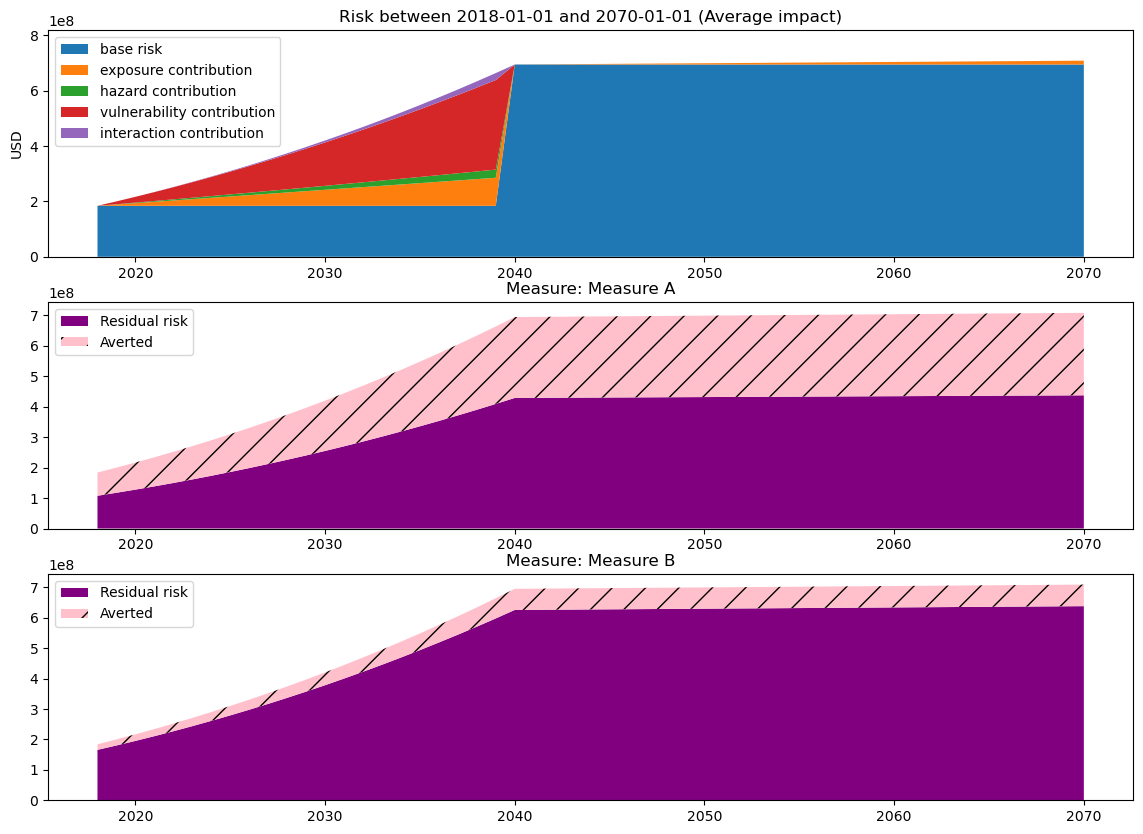

In [29]:
appraiser.plot_per_date_waterfall_CB()

In [30]:
appraiser.per_date_CB()

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:00<00:00, 1054.59it/s]


,date,group,measure,metric,risk,reference risk,averted risk,measure net cost,measure cost benefit,cumulated measure cost,cumulated measure benefit,cost/benefit ratio
0,2018-01-01,All,no_measure,aai,1.840432e+08,1.840432e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2019-01-01,All,no_measure,aai,2.000396e+08,2.000396e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2020-01-01,All,no_measure,aai,2.166844e+08,2.166844e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2021-01-01,All,no_measure,aai,2.339834e+08,2.339834e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2022-01-01,All,no_measure,aai,2.519424e+08,2.519424e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
207,2069-01-01,1,Measure B,aai,6.363402e+08,7.070447e+08,7.070447e+07,1950.0,7.070252e+07,3.132076e+10,1.508532e+12,0.020762
208,2070-01-01,0,Measure A,aai,6.442936e+05,1.061695e+06,4.174011e+05,500.0,4.169011e+05,3.132076e+10,1.508533e+12,0.020762
209,2070-01-01,1,Measure A,aai,4.369031e+08,7.075071e+08,2.706041e+08,500.0,2.706036e+08,3.132076e+10,1.508803e+12,0.020759
210,2070-01-01,0,Measure B,aai,9.555252e+05,1.061695e+06,1.061695e+05,1950.0,1.042195e+05,3.132076e+10,1.508803e+12,0.020759


In [31]:
appraiser.per_period_CB()

100%|██████████| 106/106 [00:00<00:00, 1334.14it/s]


,period,measure,group,metric,reference risk,averted risk,risk,measure net cost,measure cost benefit
0,2018-01-01 to 2070-01-01,Measure A,0,aai,4.569804e+07,1.810624e+07,2.759180e+07,5.000026e+09,-4.981919e+09
1,2018-01-01 to 2070-01-01,Measure A,1,aai,3.048967e+10,1.175759e+10,1.873208e+10,5.000026e+09,6.757567e+09
2,2018-01-01 to 2070-01-01,Measure A,All,aai,3.053537e+10,1.177570e+10,1.875967e+10,5.000026e+09,6.775673e+09
3,2018-01-01 to 2070-01-01,Measure A,All,rp_100,1.018197e+12,4.038471e+11,6.143504e+11,5.000026e+09,3.988471e+11
4,2018-01-01 to 2070-01-01,Measure A,All,rp_50,5.930228e+11,3.045917e+11,2.884311e+11,5.000026e+09,2.995917e+11
5,2018-01-01 to 2070-01-01,Measure A,All,rp_500,2.436424e+12,3.660124e+11,2.070412e+12,5.000026e+09,3.610124e+11
6,2018-01-01 to 2070-01-01,Measure B,0,aai,4.569804e+07,4.569804e+06,4.112824e+07,2.201014e+08,-2.155315e+08
7,2018-01-01 to 2070-01-01,Measure B,1,aai,3.048967e+10,3.048967e+09,2.744070e+10,2.201014e+08,2.828865e+09
8,2018-01-01 to 2070-01-01,Measure B,All,aai,3.053537e+10,3.053537e+09,2.748183e+10,2.201014e+08,2.833435e+09
9,2018-01-01 to 2070-01-01,Measure B,All,rp_100,1.018197e+12,1.018197e+11,9.163777e+11,2.201014e+08,1.015996e+11


In [32]:
appraiser.eai_metrics()

100%|██████████| 106/106 [00:00<00:00, 290.59it/s]


,date,group,measure,metric,coord_id,risk,reference risk,averted risk,measure net cost,measure cost benefit
0,2018-01-01,0,no_measure,eai,2,983.793263,983.793263,0.000000,0.0,0.000000
3,2018-01-01,0,no_measure,eai,3,880.220041,880.220041,0.000000,0.0,0.000000
6,2018-01-01,0,no_measure,eai,4,613.657134,613.657134,0.000000,0.0,0.000000
9,2018-01-01,0,no_measure,eai,5,788.751994,788.751994,0.000000,0.0,0.000000
12,2018-01-01,0,no_measure,eai,6,807.108756,807.108756,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
140869,2070-01-01,1,Measure B,eai,1319,12890.609025,14322.898917,1432.289892,1950.0,-517.710108
140870,2070-01-01,1,Measure B,eai,1323,3591.186992,3990.207769,399.020777,1950.0,-1550.979223
140871,2070-01-01,1,Measure B,eai,1324,3785.519027,4206.132252,420.613225,1950.0,-1529.386775
140872,2070-01-01,1,Measure B,eai,1327,5295.730251,5884.144723,588.414472,1950.0,-1361.585528


In [33]:
from climada.engine.option_appraisal.appraiser import PlannedMeasuresAppraiser

In [34]:
planner = {"Measure A": (2030, 2050), "Measure B": (2018, 2030)}

planned = PlannedMeasuresAppraiser(snapcol, measure_set=meas_set, planner=planner)

100%|██████████| 265/265 [00:00<00:00, 1074.74it/s]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

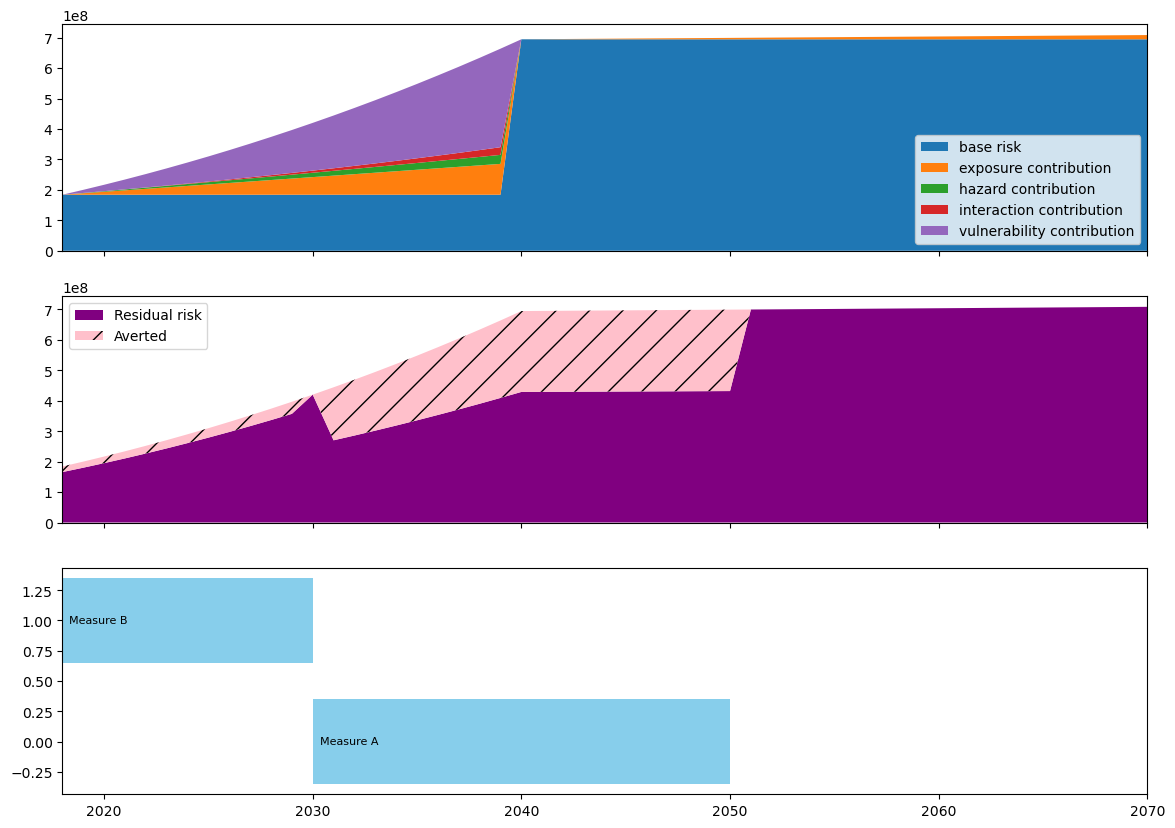

In [35]:
planned.plot_per_date_waterfall_CB()

In [36]:
?planned

Type:            PlannedMeasuresAppraiser
String form:     <climada.engine.option_appraisal.appraiser.PlannedMeasuresAppraiser object at 0x32329b390>
File:            ~/Documents/Programming/Climate/climada_python/climada/engine/option_appraisal/appraiser.py
Docstring:       <no docstring>
Class docstring:
Calculates risk trajectories over a series of snapshots.

This class computes risk metrics over a series of snapshots,
optionally applying risk discounting and risk transfer adjustments.

Attributes
----------
start_date : datetime
    The start date of the risk trajectory.
end_date : datetime
    The end date of the risk trajectory.
risk_disc : DiscRates | None
    The discount rates for risk, default is None.
risk_transf_cover : optional
    The risk transfer coverage, default is None.
risk_transf_attach : optional
    The risk transfer attachment, default is None.
risk_periods : list
    The computed RiskPeriod objects from the snapshots.